# *Яндекс ПРАКТИКУМ*

# **ПРОЕКТ: Прогнозирование заказов такси**

# Выполнил: *Мирослав Г.*

# email: 

# Дата: 07.2023

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import re
import math as mt
from math import factorial
import scipy.stats
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os

import seaborn as sns
from datetime import datetime

plt.style.use('dark_background')

import lightgbm as lgb
from lightgbm import LGBMRegressor


from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.dummy import  DummyRegressor

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
try:
    df = pd.read_csv("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx\\taxi.csv", index_col = [0], parse_dates = [0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col = [0], parse_dates = [0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Вывод:
Провели загрузку датасета, состоящего из двух колонок и 26496 строк. При загрузке, заменили индексы на колонку datetime и преобразовали данные в этой колонке в формат datetime64[ns]. Провели ресемплирование по одному часу.

## Анализ

In [6]:
# Посмотрим распределение заказов по дням недели, для этого создадим отдельный датасет с ресамплированием по дням

df_wd = df.resample('D').median()
df_wd['dayofweek'] = df_wd.index.day_name()
df_wd.groupby('dayofweek')['num_orders'].agg('sum')

dayofweek
Friday       2433.5
Monday       2236.0
Saturday     2073.0
Sunday       2018.5
Thursday     2283.5
Tuesday      1995.5
Wednesday    2145.0
Name: num_orders, dtype: float64

*Как видно, наибольшее число заказов по пятницам. Для дальнейшего анализа вернемся к первоначальному датасету*

In [7]:
# Проверим данные в колонках на хронологичность

df.index.is_monotonic

True

In [8]:
# Для анализа временного ряда используем созданную ранее переменную df_wd, которую приведем к виду исходного датасета

df_wd = df.copy()

In [9]:
# Добавим сглаживание скользящей средней

df_wd['rolling_mean'] = df_wd['num_orders'].rolling(24).mean()

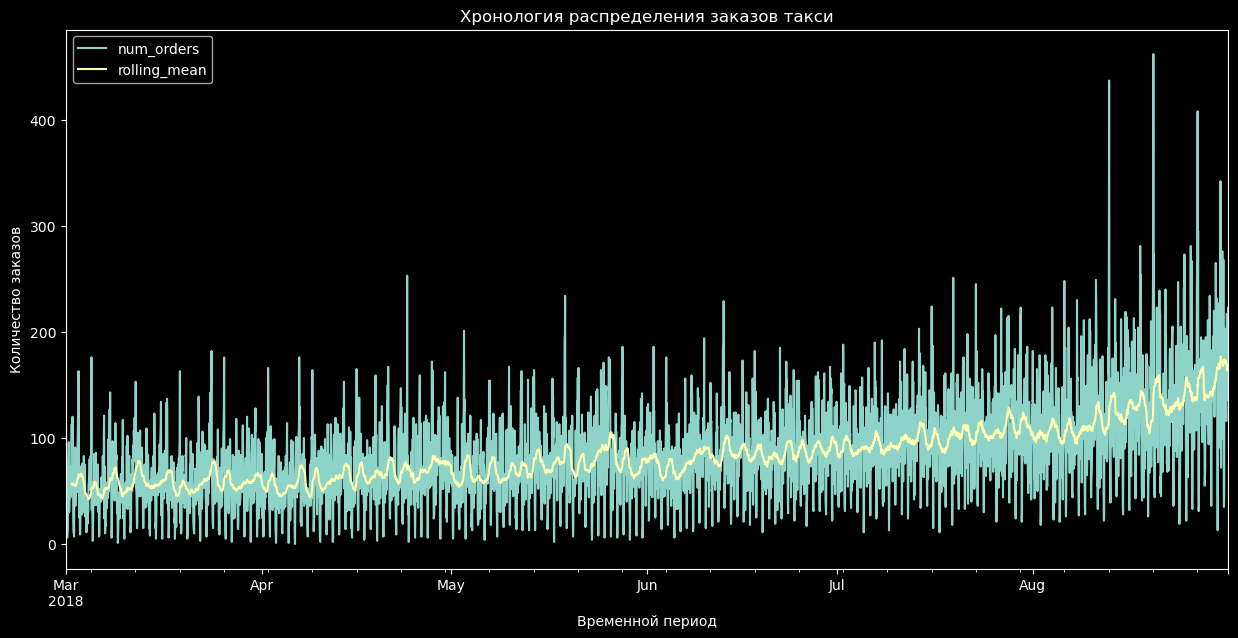

In [10]:
# Построим график распределения заказов такси по времени

df_wd.plot(figsize=[15,7], title='Хронология распределения заказов такси', xlabel='Временной период', ylabel='Количество заказов');

*Из графика видно, что временной ряд является нестационарным с изменением распределения значений и возрастанием скользящего среднего к концу ряда.* 

In [11]:
'''
H_0: гипотеза о нестацинарности ряда.
H_1: альтернатива - гипотеза о стационарности ряда
alpha = 0.05 и alpha = 0.01
'''

alpha_1 = 0.01    # alpha - значение уровня значимости
alpha_5 = 0.05

result = adfuller(df_wd['num_orders'], autolag = 't-stat')

print('Критерий ADF: %f' % result[0]) 

print('P-значение: %f' % result[1]) # вывод значения p-value на экран 
print()
print('1 вариант уровня значимости равного 1%')
if result[1] < alpha_1: 
    print ("Нулевая гипотеза отвергнута – Временной ряд не стационарен")  
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд стационарен")
print()
print('2 вариант уровня значимости равного 5%')
if result[1] < alpha_5: 
    print ("Нулевая гипотеза отвергнута – Временной ряд не стационарен")  
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940

1 вариант уровня значимости равного 1%
Нулевая гипотеза не отвергнута – Временной ряд стационарен

2 вариант уровня значимости равного 5%
Нулевая гипотеза отвергнута – Временной ряд не стационарен


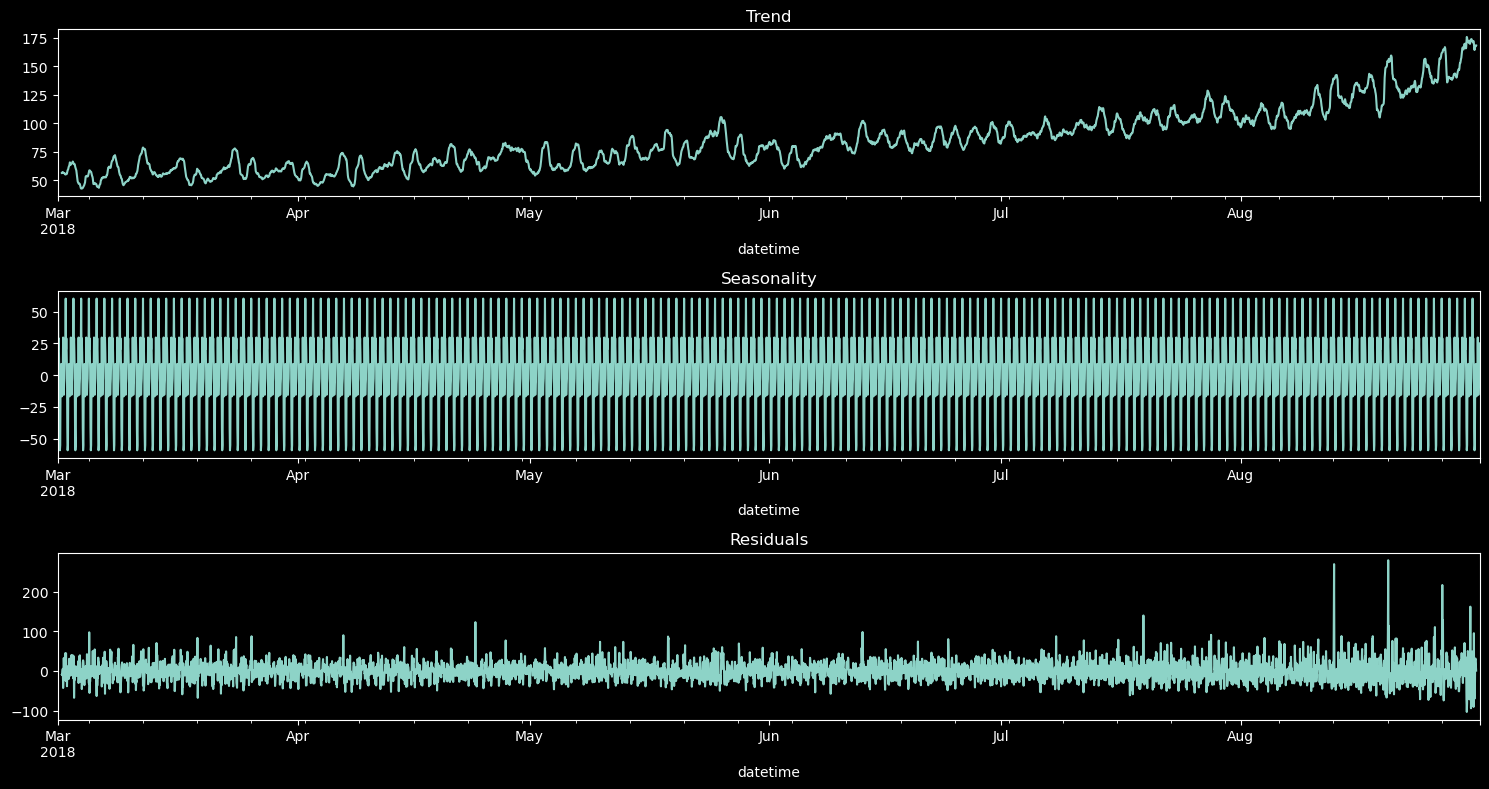

In [12]:
# Построим графики Тренда, Сезонности и остатка

decomposed = seasonal_decompose(df) 

plt.figure(figsize=(15, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

*Как видно из графика тренда, наблюдается тенденция к росту заказов такси. Однако нужно учитывать, что датасет охватывает не весь год и возвожна смена тренда, после "отпускного" сезона.*\

*Также наблюдается сезонность в изменении данных, которая повторяется каждые 24 часа.*

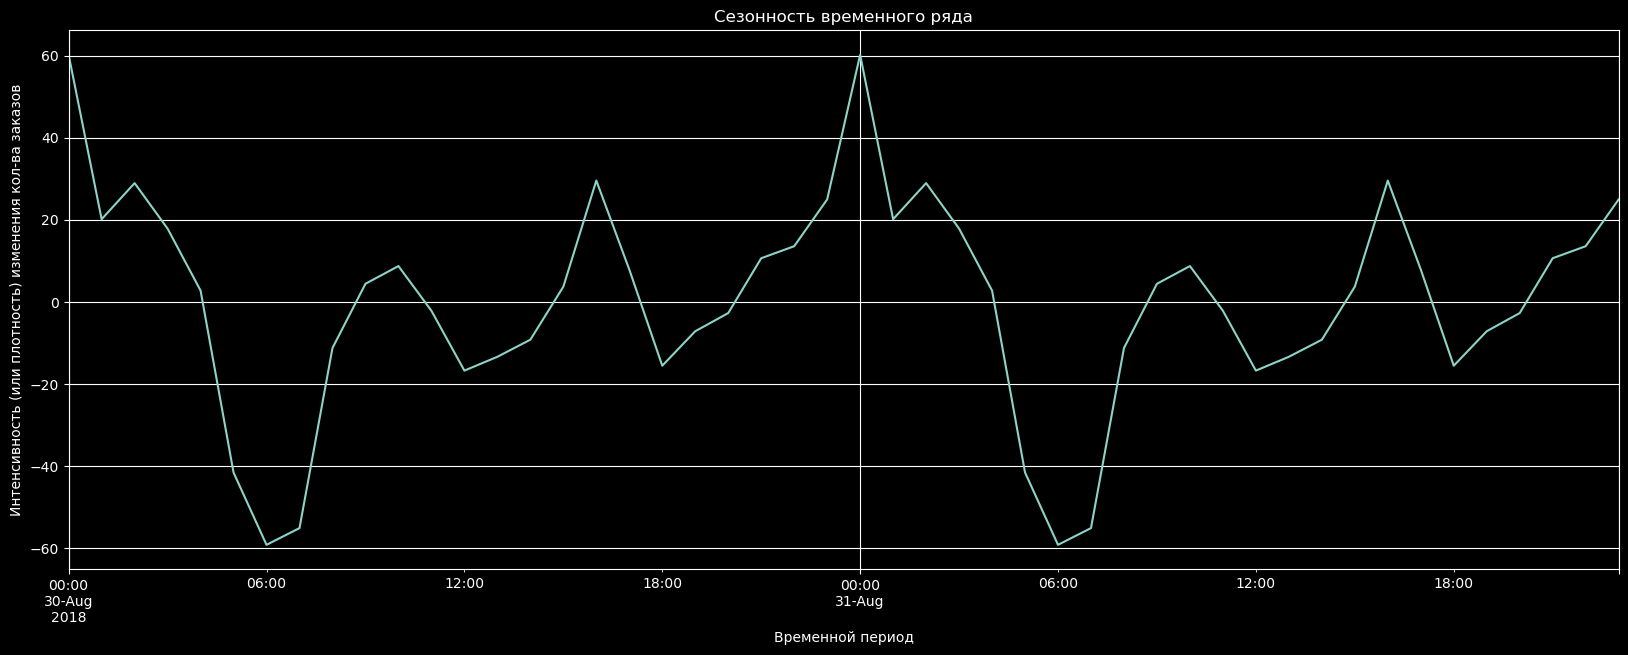

In [13]:
decomposed = seasonal_decompose(df)
decomposed = decomposed.seasonal['2018-08-30':'2018-08-31']
decomposed.plot(figsize=(20, 7), grid=True, title='Сезонность временного ряда',
                 xlabel='Временной период', ylabel='Интенсивность (или плотность) изменения кол-ва заказов');

*График сезонности показывает распределение ИЗМЕНЕНИЙ заказов такси втечение суток. Как видно, ночью интенсивность заказов падает, а с 6:00 до 00 часов возрастает, с двумя периодами снижения: в 12 и в 18 часов.* 

*Сезонность обусловлена работой аэропорта, расписанием прилетов/вылетов самолетов и пассажиропотоком. Соответственно, ночью, видимо, пассажиропоток ниже, чем в течение дня, поэтому заказов такси днем больше чем ночью. Также, возможно, влияние пересменок персонала и обеденным временем, когда персонал приезжает/уезжат на работу или заказывает обед и т.д. В итоге, наблюдается 5 всплесков активности за сутки.*

In [14]:
# Построим график 24-ёх периодной скользящей средней и график страндартного отклонения от скользящей средней

orders = pd.Series(
    df['num_orders'],
    index=pd.date_range(end="2018-8-31", periods=720, freq="1H")
)
# приведем ряд к стационарному виду
orders = orders - orders.shift(24)
# постром скользящую среднюю
ma = orders.rolling(24).mean()
# построим отклонение от скользящей средней
mstd = orders.rolling(24).std()

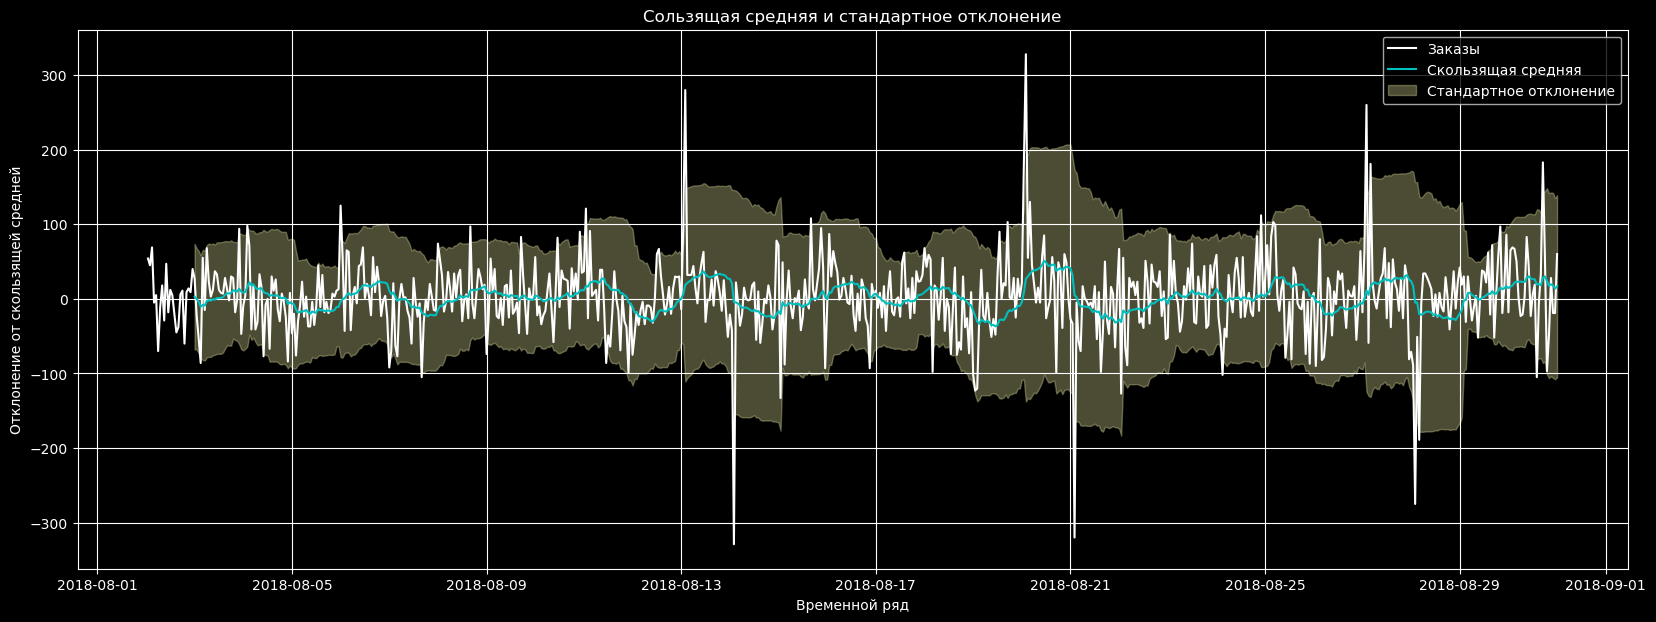

In [15]:
plt.figure(figsize=(20, 7));
plt.plot(orders.index, orders, "w", label = 'Заказы');
plt.plot(ma.index, ma, "c", label = 'Скользящая средняя');
plt.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="#ffffb3", alpha=0.3, label = 'Стандартное отклонение');
plt.title('Сользящая средняя и стандартное отклонение')
plt.xlabel('Временной ряд')
plt.ylabel('Отклонение от скользящей средней')
plt.legend(loc='best')
plt.grid(True)
plt.show()

*Анализ графика позволяет предположить снижение интенсивности потока заказов, на основаниии снижения максимальных значений всплесков, и сделанного ранее предположения об окончании "отпускного" сезона.*

In [16]:
# Создадим признаки для моделей

def make_features(df_foo, max_lag, rolling_mean_size):
    data = df_foo.copy()
    data['week'] = data.index.week
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

df = make_features(df, 24, 24)
df.tail(2)

,num_orders,week,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 22:00:00,223,35,31,4,159.0,154.0,136.0,207.0,217.0,197.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,166.416667
2018-08-31 23:00:00,205,35,31,4,223.0,159.0,154.0,136.0,207.0,217.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,169.125000


In [17]:
# Разделим выборку на Обучающую и Тестовую

train, test = train_test_split(df, shuffle=False, test_size=0.1) # нам нужны данные за всё время. 
# Из обучающей выборки удалим строки с пропусками.
train = train.dropna() 

print(train.shape)
print(test.shape)

(3950, 29)
(442, 29)


In [18]:
# Разделим признаки в Обучающей и Тестовой выборках на Обучающие признаки и Целевой признак

features_train = train.drop(['num_orders'] , axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'] , axis=1)
target_test = test['num_orders']

## Обучение

In [19]:
def rmse(target, predictions):
    error = (mean_squared_error(target, predictions))**0.5
    return error

score = make_scorer(rmse, greater_is_better=False)

*Линейная регрессия*

In [20]:
# Обучим модель LinearRegression

lr_model = LinearRegression()

param_grid = {}

lr_gs = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring=score, cv=TimeSeriesSplit(n_splits=5))
lr = lr_gs.fit(features_train, target_train)

print(f'Оптимальное значение гиперпараметров:_____ {lr.best_params_}')
print(f'Оптимальное значение гиперпараметров:_____ {-lr.best_score_}')

Оптимальное значение гиперпараметров:_____ {}
Оптимальное значение гиперпараметров:_____ 27.01855536222912


*LGBMRegressor*

In [21]:
lgbm = LGBMRegressor(objective = "regression", metric = "rmse", verbose = -1, silent = False)

param_grid = {
        "learning_rate" : [0.05, 0.1, 0.5], 
        'num_iterations' : [100, 200],
        'num_leaves': [31, 51, 71]        
        }

gbm_gs = GridSearchCV(lgbm, param_grid = param_grid, scoring=score, cv=TimeSeriesSplit(n_splits=5))
gbm = gbm_gs.fit(features_train, target_train)

print(f'Оптимальное значение гиперпараметров:_____ {gbm.best_params_}')
print(f'Оптимальное значение гиперпараметров:_____ {-gbm.best_score_}')

Оптимальное значение гиперпараметров:_____ {'learning_rate': 0.05, 'num_iterations': 100, 'num_leaves': 51}
Оптимальное значение гиперпараметров:_____ 25.63978839936022


*RandomForestRegressor*

In [22]:
train_rfr = RandomForestRegressor()
param_grid = {
    'n_estimators': range(1, 31, 10),
    'max_depth': [None] + [i for i in range(2, 7)],
    'min_samples_leaf': range(2, 5)
    }

cv_rfr = GridSearchCV(estimator=train_rfr, param_grid=param_grid, scoring=score, 
                      cv=TimeSeriesSplit(n_splits=5))

cv_rfr.fit(features_train, target_train)
predicted_train_rfr = cv_rfr.predict(features_train)

print(f'Оптимальное значение гиперпараметров:_____ {cv_rfr.best_params_}')
print(f'Оптимальное значение гиперпараметров:_____ {-cv_rfr.best_score_}')

Оптимальное значение гиперпараметров:_____ {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 21}
Оптимальное значение гиперпараметров:_____ 26.142121978813343


In [23]:
# Сведем полученные результаты наилучших значений метрики для разных моделей в Таблицу

result = pd.DataFrame(
    [(-lr.best_score_), (-gbm.best_score_), (-cv_rfr.best_score_)], 
    index=['LinearRegression',  'LGBMRegressor', 'RandomForestRegressor'], 
    columns=['RMSE']
)
result

,RMSE
LinearRegression,27.018555
LGBMRegressor,25.639788
RandomForestRegressor,26.142122


### Вывод:
Как видно из полученных результатов, наименьшее значение метрики у модели LGBMRegressor. Поэтому для тестирования применим эту модель.

## Тестирование

In [24]:
# протестируем отобранную модель

predicted_gbm = gbm.predict(features_test)

print("RMSE для анализа моделей =", mean_squared_error(target_test, predicted_gbm) ** 0.5)

RMSE для анализа моделей = 43.63223253867168


*Dummy регрессия*

In [25]:
train_dum = DummyRegressor(strategy="mean")

dummy = train_dum.fit(features_train, target_train)

predicted_dum = dummy.predict(features_test)

print("RMSE для анализа моделей =", mean_squared_error(target_test, predicted_dum) ** 0.5)

RMSE для анализа моделей = 84.6499381993622


### Вывод:
Константная модель показала результат много хуже чем тестовая. Это свидетельствует об эффективности полученной модели.

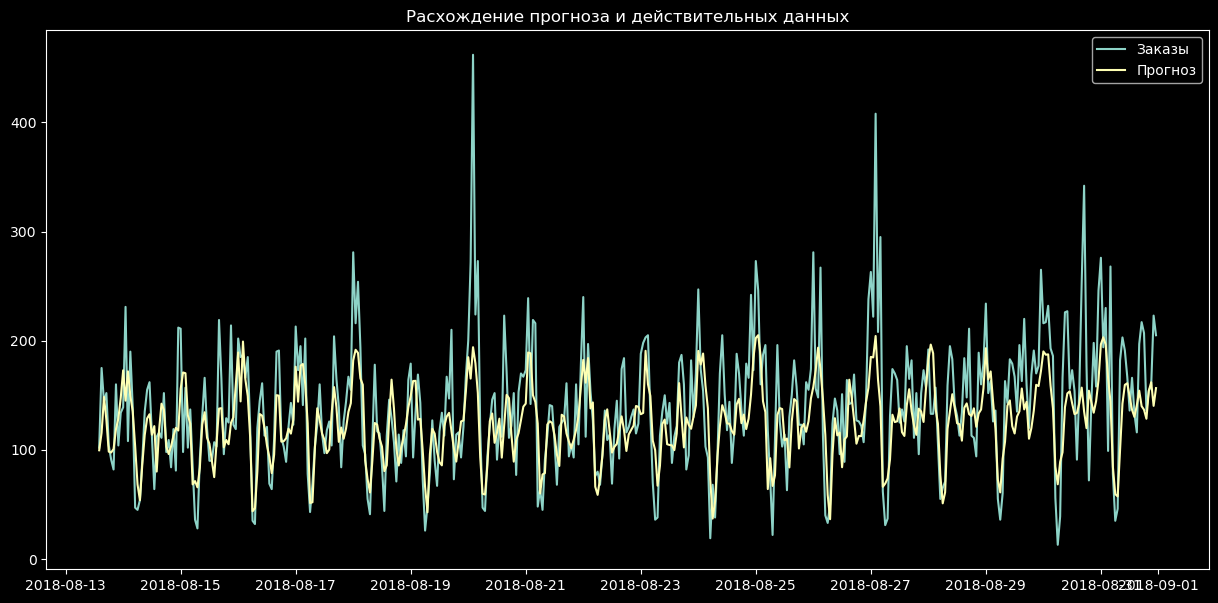

In [26]:
plt.figure(figsize=(15, 7)) 
plt.plot(target_test.index, target_test,  label='Заказы')
plt.plot(target_test.index, predicted_gbm,  label='Прогноз')
plt.legend(loc='best')
plt.title('Расхождение прогноза и действительных данных')
plt.show()

## Общий вывод

В задачу проекта входила разработка модели для прогноза количества заказов такси на следующий час. Модель должна выдавать предсказания, точность которых оценивается метрикой RMSE и не превышает 48. 

Для исследования был предоставлен датасет состоящий из двух колонок и 26496 строк. При загрузке, заменили индексы на колонку datetime и преобразовали данные в этой колонке в формат datetime64[ns]. Провели ресемплирование по одному часу.

В процессе работы был проведен анализ временного ряда, определены тренд и сезонность по которым определены тенденции построения предсказания.

При обучении  выбрали 3 варианта моделей: LinearRegression, LGBMRegressor,  RandomForestRegressor. Одна из моделей относится к моделям градиентного бустинга.

В результате исследования получили следующи данные:
- лучшее значение метрики RMSE при Обучении  показала модель LGBMRegressor - 25.64

Результат: Наилучшая модель - LGBMRegressor
Значения метрик наилучшей модели:  RMSE - 43,63